## 1、引言

在实际场景中，很多数据集都是多维度的。随着维度的增加，数据空间的大小（体积）会以指数级别增长，使数据变得稀疏，这便是维度诅咒的难题。维度诅咒不止给异常检测带来了挑战，对距离的计算，聚类都带来了难题。例如基于邻近度的方法是在所有维度使用距离函数来定义局部性，但是，在高维空间中，所有点对的距离几乎都是相等的（距离集中），这使得一些基于距离的方法失效。在高维场景下，一个常用的方法是子空间方法。

集成是子空间思想中常用的方法之一，可以有效提高数据挖掘算法精度。集成方法将多个算法或多个基检测器的输出结合起来。其基本思想是一些算法在某些子集上表现很好，一些算法在其他子集上表现很好，然后集成起来使得输出更加鲁棒。集成方法与基于子空间方法有着天然的相似性，子空间与不同的点集相关，而集成方法使用基检测器来探索不同维度的子集，将这些基学习器集合起来。

下面来介绍两种常见的集成方法：

## 2、Feature Bagging

Feature Bagging，基本思想与bagging相似，只是对象是feature。feature bagging属于集成方法的一种。集成方法的设计有以下两个主要步骤：

**1.选择基检测器**。这些基本检测器可以彼此完全不同，或不同的参数设置，或使用不同采样的子数据集。Feature bagging常用lof算法为基算法。

**2.分数标准化和组合方法**：不同检测器可能会在不同的尺度上产生分数。例如，平均k近邻检测器会输出原始距离分数，而LOF算法会输出归一化值。另外，尽管一般情况是输出较大的异常值分数，但有些检测器会输出较小的异常值分数。因此，需要将来自各种检测器的分数转换成可以有意义的组合的归一化值。分数标准化之后，还要选择一个组合函数将不同基本检测器的得分进行组合，最常见的选择包括平均和最大化组合函数。

基探测器的设计及其组合方法都取决于特定集成方法的特定目标。很多时候，我们无法得知数据的原始分布，只能通过部分数据去学习。除此以外，算法本身也可能存在一定问题使得其无法学习到数据完整的信息。这些问题造成的误差通常分为偏差和方差两种。

**方差**：是指算法输出结果与算法输出期望之间的误差，描述模型的离散程度，数据波动性。

**偏差**：是指预测值与真实值之间的差距。即使在离群点检测问题中没有可用的基本真值

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager


导入想要用来检测数据集中异常值的模型。 我将使用ABOD（基于角度的异常值检测器）和KNN（K最近邻居）：

In [3]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN


创建一个带有异常值的随机数据集并绘制：

Text(0, 0.5, 'F2')

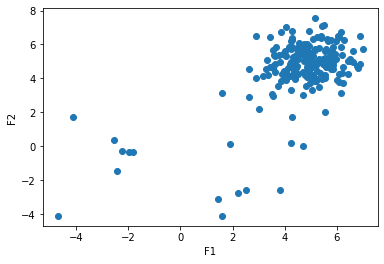

In [4]:
from pyod.utils.data import generate_data, get_outliers_inliers

#generate random data with two features
X_train, Y_train = generate_data(n_train=200,train_only=True, n_features=2)

# by default the outlier fraction is 0.1 in generate data function 
outlier_fraction = 0.1

# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train,Y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

#separate the two features and use it to plot the data 
F1 = X_train[:,[0]].reshape(-1,1)
F2 = X_train[:,[1]].reshape(-1,1)

# create a meshgrid 
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))

# scatter plot 
plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2') 


创建一个字典并添加要用于检测异常值的所有模型：

In [5]:
classifiers = {
     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
     'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}


将数据拟合到我们在字典中添加的每个模型，然后，查看每个模型如何检测异常值：

No of Errors :  Angle-based Outlier Detector (ABOD) 15
No of Errors :  K Nearest Neighbors (KNN) 5


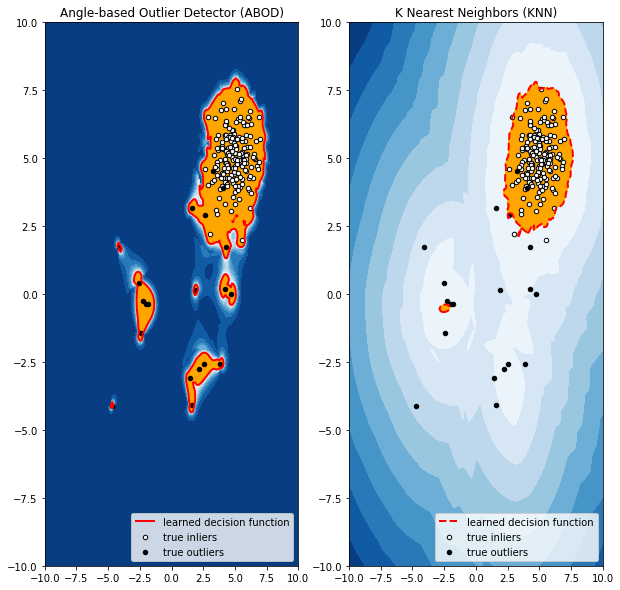

In [6]:
#set the figure size
plt.figure(figsize=(10, 10))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)

    # no of errors in prediction
    n_errors = (y_pred != Y_train).sum()
    print('No of Errors : ',clf_name, n_errors)

    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

    subplot.set_title(clf_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show() 


## 3、Isolation Forests

孤立森林（Isolation Forest）算法是周志华教授等人于2008年提出的异常检测算法，是机器学习中少见的专门针对异常检测设计的算法之一，方法因为该算法时间效率高，能有效处理高维数据和海量数据，无须标注样本，在工业界应用广泛。

孤立森林属于非参数和无监督的算法，既不需要定义数学模型也不需要训练数据有标签。孤立森林查找孤立点的策略非常高效。假设我们用一个随机超平面来切割数据空间，切一次可以生成两个子空间。然后我们继续用随机超平面来切割每个子空间并循环，直到每个子空间只有一个数据点为止。直观上来讲，那些具有高密度的簇需要被切很多次才会将其分离，而那些低密度的点很快就被单独分配到一个子空间了。孤立森林认为这些很快被孤立的点就是异常点。

怎么来切这个数据空间是孤立森林的核心思想。因为切割是随机的，为了结果的可靠性，要用集成（ensemble）的方法来得到一个收敛值，即反复从头开始切，平均每次切的结果。孤立森林由t棵孤立的数组成，每棵树都是一个随机二叉树，也就是说对于树中的每个节点，要么有两个孩子节点，要么一个孩子节点都没有。树的构造方法和随机森林(random forests)中树的构造方法有些类似。流程如下：

1. ```
    从训练数据中随机选择一个样本子集，放入树的根节点；
   ```

2. ```
    随机指定一个属性，随机产生一个切割点V，即属性A的最大值和最小值之间的某个数；
   ```

3. ```
    根据属性A对每个样本分类，把A小于V的样本放在当前节点的左孩子中，大于等于V的样本放在右孩子中，这样就形成了2个子空间；
   ```

获得t棵树之后，孤立森林的训练就结束，就可以用生成的孤立森林来评估测试数据。

孤立森林检测异常的假设是：异常点一般都是非常稀有的，在树中会很快被划分到叶子节点，因此可以用叶子节点到根节点的路径长度来判断一条记录是否是异常的。和随机森林类似，孤立森林也是采用构造好的所有树的平均结果形成最终结果的。在训练时，每棵树的训练样本是随机抽样的。从孤立森林的树的构造过程看，它不需要知道样本的标签，而是通过阈值来判断样本是否异常。因为异常点的路径比较短，正常点的路径比较长，孤立森林根据路径长度来估计每个样本点的异常程度。

孤立森林也是一种基于子空间的方法，不同的分支对应于数据的不同局部子空间区域，较小的路径对应于孤立子空间的低维。


On Training Data:
IForest ROC:0.9972, precision @ rank n:0.9

On Test Data:
IForest ROC:1.0, precision @ rank n:1.0


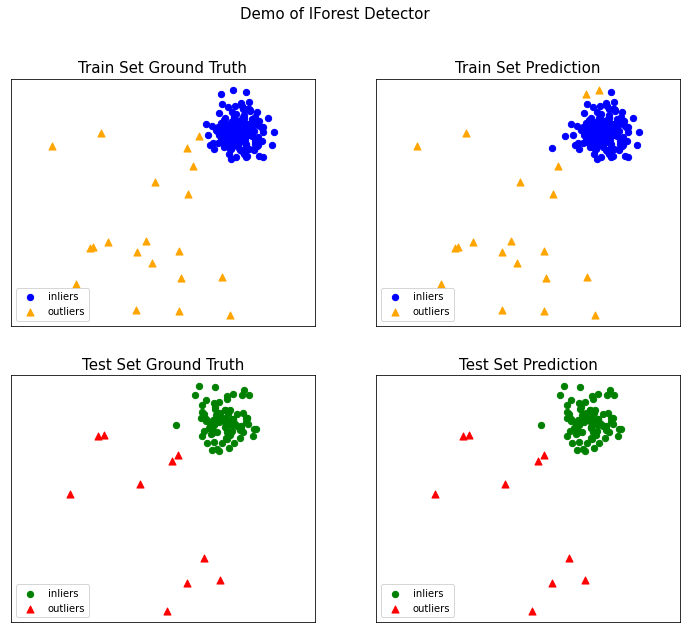

In [7]:
from __future__ import division
from __future__ import print_function

import os
import sys

from pyod.models.iforest import IForest
from pyod.utils.data import generate_data

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

if __name__ == "__main__":
    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    X_train, y_train, X_test, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train IForest detector
    clf_name = 'IForest'
    clf = IForest()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=False)


## 4、总结

1.feature bagging可以降低方差

2.孤立森林的优势在于：

- 计算成本相比基于距离或基于密度的算法更小。
- 具有线性的时间复杂度。
- 在处理大数据集上有优势。

孤立森林不适用于超高维数据，因为鼓励森林每次都是随机选取维度，如果维度过高，则会存在过多噪音。